# Import and helper function

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn, optim

from sklearn import decomposition
import seaborn as sns

In [2]:
!pip install tqdm
from tqdm.notebook import tqdm

In [3]:
# Images are column vectors
def visualize_image(X, n_row=5, n_col=5, rand=True, image_size=[32, 32]):
    for idx in range(n_row * n_col):
        if rand:
            image_id = np.random.randint(0, X.shape[1])
        else:
            image_id = idx

        image = X[:, image_id].reshape(image_size)

        plt.subplot(n_row, n_col, idx + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

# CIFAR 10

### Load dataset

In [ ]:
from torchvision import datasets, transforms

cifar10 = datasets.CIFAR10(root='.', download=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: transforms.functional.adjust_saturation(x,0))
                        ]))


Files already downloaded and verified


In [ ]:
batch_size = 50000
data_loader = torch.utils.data.DataLoader(cifar10, batch_size=batch_size, shuffle=True, \
                                          num_workers=4, drop_last = True)
X = next(iter(data_loader))[0]
X = X.view(batch_size, 3, -1).mean(1).T

### Visualization

(1024, 50000)
0.0
0.99990004


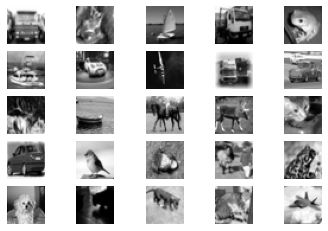

In [ ]:
X = X.numpy()
print(X.shape)
print(X.min())
print(X.max())
visualize_image(X)

# Image Net

### Load dataset

In [4]:
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1mF46SUDKzG0LkWkNGV1fP2hTEgW5WbF_',
                                    dest_path='./imagenet_32x32_crops.pt',
                                    unzip=False, overwrite = True, showsize=True)

1.1 GiB Done.


In [5]:
imagenet = torch.load('imagenet_32x32_crops.pt')
X = imagenet.view([imagenet.shape[0], 3, -1]).mean(1).T.numpy()

### Visualization

(1024, 100352)
0.0
1.0


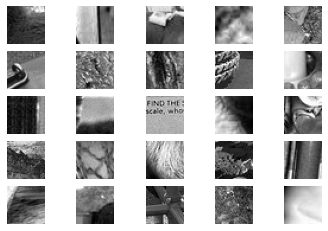

In [6]:
print(X.shape)
print(X.min())
print(X.max())
visualize_image(X)

# PCA Analysis

In [7]:
# Zero center
row_mean = X.mean(axis=1)
X_zero = X - row_mean.reshape([-1, 1])

In [8]:
# PCA
pca = decomposition.PCA()
pca.fit(X_zero.T)
pca_basis = pca.components_
pca_basis.shape

(1024, 1024)

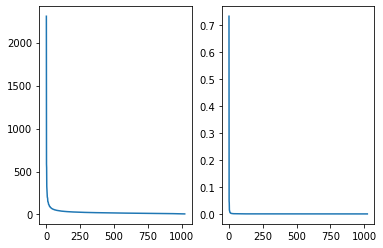

In [9]:
# Plot eigenval
plt.subplot(1, 2, 1)
plt.plot(pca.singular_values_)

plt.subplot(1, 2, 2)
plt.plot(pca.explained_variance_ratio_)
plt.show()

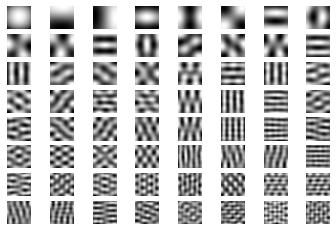

In [10]:
# PCA Basis
visualize_image(pca_basis.T, n_row=8, n_col=8, rand=False)

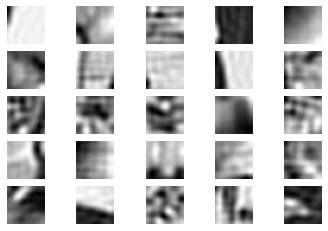

In [11]:
# PCA transformation
n_comp = 50
comp = pca_basis[:n_comp, :]

proj = comp @ X_zero
recon = comp.T @ proj
recon_mean = recon + row_mean.reshape([-1, 1])

visualize_image(recon_mean)

In [12]:
# PCA loss
loss_func = nn.MSELoss()
loss_func(torch.from_numpy(X_zero.T.astype(np.float32)), \
          torch.from_numpy(recon.T.astype(np.float32)))

tensor(0.0047)

# PCA with Neural Network

### Helper class and function

In [13]:
input_X = torch.from_numpy(X_zero.T.astype(np.float32)).cuda()

import functools as ft
class LinearNetwork:
  # init with a list of weight matrix
  def __init__(self, pca_basis, init_scale, *weight_shape):
    self.weight = [(torch.rand(mtx_shape)*init_scale-init_scale/2)\
                   .clone().detach().cuda().requires_grad_(True)\
                   for mtx_shape in weight_shape]

    self.pca_basis = torch.from_numpy(pca_basis.astype(np.float32)).cuda()

  def transform_mtx(self):
    # pca transformation encoded by the network
    w = ft.reduce(lambda a, b: b.mm(a), self.weight)
    return w.t().mm(w)

  def forward(self, input):
    # forward transformation on data
    transform = self.transform_mtx()
    return input.mm(transform)
    
  def decompose(self):
    # alignment with PCA basis
    with torch.no_grad():
      transform = self.transform_mtx()
      diag = self.pca_basis.mm(transform).mm(self.pca_basis.T)      

      return np.diag(diag.detach().cpu().numpy())

  # useful visualization
  def plot_decomposition(self, n_item):
    diag = self.decompose()[:n_item]
    plt.plot(diag)
    plt.show()

  def show_reconstruction(self, input):
    with torch.no_grad():
      output = self.forward(input).detach().cpu().numpy().T
      visualize_image(output)


In [14]:
def pca_learning(input, network, n_epoch=1000, batch_size=100, n_item=50, sgd=True, lr=0.01):
  # Gradient descent training
  optimizer = optim.SGD(network.weight, lr=lr)  
  if not sgd:
    optimizer = optim.Adam(network.weight)

  loss_func = nn.MSELoss()
  loss_val  = np.zeros(n_epoch)
  diag_val  = np.zeros([n_epoch, n_item])

  for epoch in tqdm(range(n_epoch)):    
    # diagonalization of network transformation with PCA basis
    diag = network.decompose()
    diag_val[epoch, :] = diag[0:n_item]
    
    # SGD training
    shuffle_idx = np.random.permutation(len(input))
    batches = torch.split(input[shuffle_idx], batch_size)
    
    for batch in batches:
        optimizer.zero_grad()
        output = network.forward(batch)
    
        loss = loss_func(batch, output)
        loss.backward()        
        optimizer.step()
        
    # evalulation after each epoch
    with torch.no_grad():
        output = network.forward(input)
        loss_val[epoch] = loss_func(input, output)

  return (loss_val, diag_val)

In [15]:
# helper function for plotting the loss function
def plot_loss(loss_val):
  fig = plt.figure(figsize=(10, 3), dpi=100)
  plt.subplot(1, 2, 1)
  plt.plot(loss_val)

  n_epoch = loss_val.size
  index = int(n_epoch * 0.75)
  plt.subplot(1, 2, 2)
  plt.plot(range(n_epoch)[index:], loss_val[index:])

In [16]:
# helper function for temporal dynamics
def plot_temporal(diag_val, t_step, n_plot=20):
  colors = sns.color_palette('Blues',n_colors=n_plot)
  for idx in range(n_plot):
    plt.plot(range(t_step), diag_val[:t_step, idx], c=colors[-(idx+1)])
  
  plt.show()

### One-Layer

#### Before training

In [17]:
n_comp = 50
input_size = 32 * 32

one_layer = LinearNetwork(pca_basis, 0.02, (n_comp, input_size))

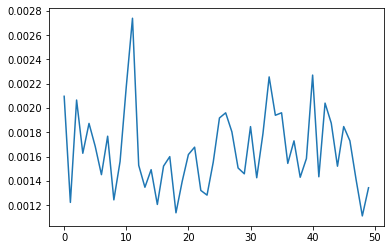

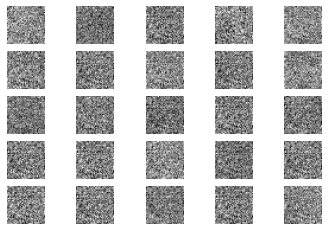

In [18]:
# Before training, diagonalization with PCA basis
one_layer.plot_decomposition(n_item=50)
one_layer.show_reconstruction(input_X)

#### Training

In [19]:
# Training
loss_val, diag_val = pca_learning(input_X, one_layer, n_epoch=1000, batch_size=500, n_item=50, sgd=True)

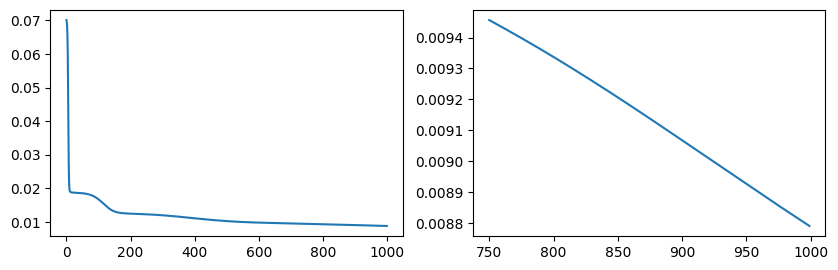

In [23]:
plot_loss(loss_val)

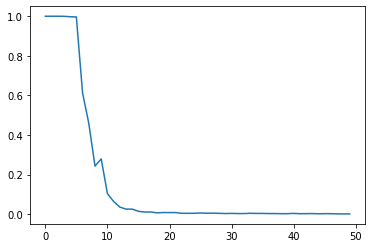

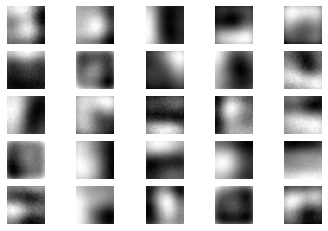

In [24]:
# After training, diagonalization with PCA basis
one_layer.plot_decomposition(n_item=50)
one_layer.show_reconstruction(input_X)

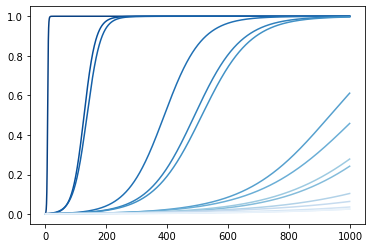

In [25]:
plot_temporal(diag_val, t_step=1000, n_plot=15)

### Three-Layer

In [26]:
n_comp = 50
input_size = 32 * 32

deep_net = LinearNetwork(pca_basis, 0.12, (75, input_size), (60, 75), (n_comp, 60))

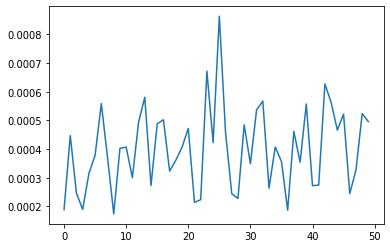

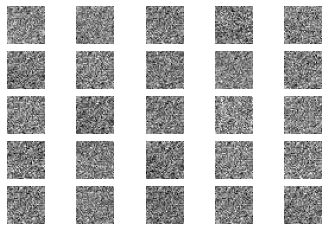

In [27]:
# Before training, diagonalization with PCA basis
deep_net.plot_decomposition(n_item=50)
deep_net.show_reconstruction(input_X)

In [28]:
# Training
n_epoch = 20000
loss_val, diag_val = pca_learning(input_X, deep_net, n_epoch=n_epoch, batch_size=1000, n_item=50, sgd=True, lr=0.1)

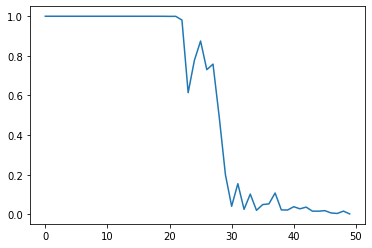

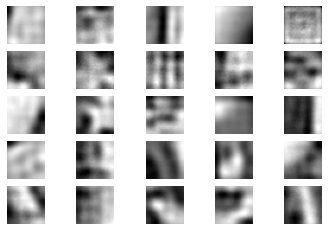

In [29]:
deep_net.plot_decomposition(n_item=50)
deep_net.show_reconstruction(input_X)

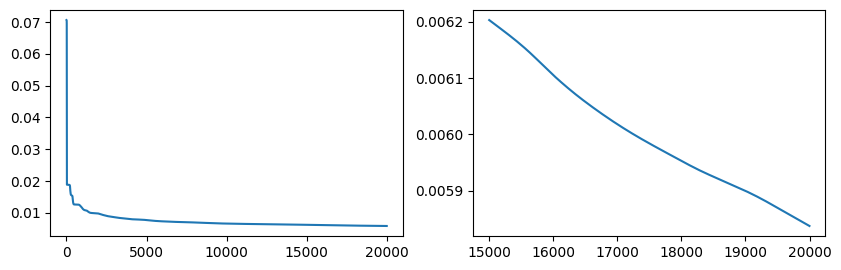

In [30]:
plot_loss(loss_val)

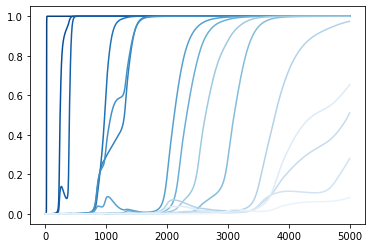

In [31]:
plot_temporal(diag_val, t_step=5000, n_plot=15)